# Importing impotant Python libraries

In [1]:
import numpy as np
import os
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.layers import Dense
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')

# Reading the csv file data and creating the Dataset

In [2]:
df = pd.read_csv("/Users/iyamahoseremem/Documents/Data_Science_Analysis_Learning/Artficial_Intelligence/ODIR-5K/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


In [3]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [4]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [5]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [6]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [7]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [8]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [9]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [10]:
print(len(cataract),len(normal))


594 500


In [11]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/Users/iyamahoseremem/Documents/Data_Science_Analysis_Learning/Artficial_Intelligence/ODIR-5K/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [12]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:01<00:00, 500.46it/s]


In [13]:
len(dataset)

588

In [14]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:01<00:00, 423.88it/s]


In [15]:
len(dataset)

1088

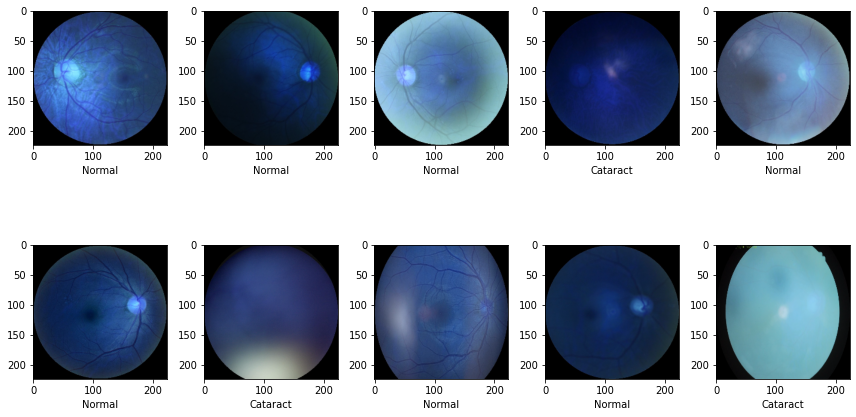

In [16]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [17]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

# Creating the Model

In [19]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
               optimizer=Adam(learning_rate=0.001),
               metrics=['accuracy']) 

In [20]:
history = model.fit(x_train,y_train,batch_size=32,epochs=55,validation_data=(x_test,y_test),
                    verbose=1)

Epoch 1/55
28/28 [==============================] - 6s 168ms/step - loss: 39.2581 - accuracy: 0.5230 - val_loss: 1.1777 - val_accuracy: 0.5872
Epoch 2/55
28/28 [==============================] - 4s 159ms/step - loss: 0.7023 - accuracy: 0.6126 - val_loss: 0.8493 - val_accuracy: 0.6193
Epoch 3/55
28/28 [==============================] - 4s 143ms/step - loss: 0.6126 - accuracy: 0.6621 - val_loss: 0.6175 - val_accuracy: 0.6147
Epoch 4/55
28/28 [==============================] - 4s 137ms/step - loss: 0.5578 - accuracy: 0.6885 - val_loss: 0.5620 - val_accuracy: 0.7431
Epoch 5/55
28/28 [==============================] - 4s 126ms/step - loss: 0.4944 - accuracy: 0.7517 - val_loss: 0.5542 - val_accuracy: 0.7294
Epoch 6/55
28/28 [==============================] - 3s 124ms/step - loss: 0.4221 - accuracy: 0.7839 - val_loss: 0.5630 - val_accuracy: 0.7110
Epoch 7/55
28/28 [==============================] - 3s 122ms/step - loss: 0.4171 - accuracy: 0.8011 - val_loss: 0.7973 - val_accuracy: 0.6697
Epoch

In [21]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 0s 38ms/step - loss: 0.4208 - accuracy: 0.9266
loss: 0.42079436779022217
Accuracy: 0.9266055822372437


# Model Evaluation

### Accuracy and Loss plots

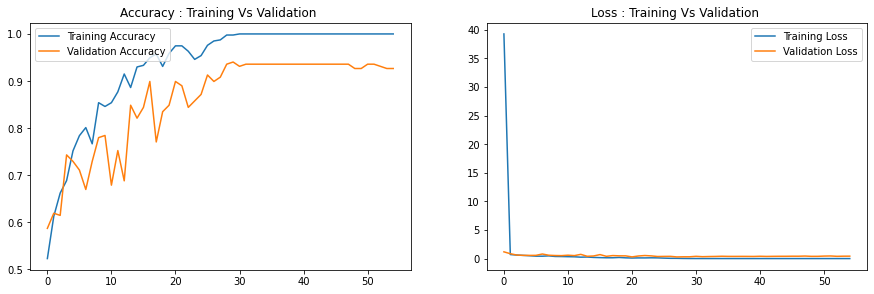

In [22]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']


plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(range(55), accuracy, label='Training Accuracy')
plt.plot(range(55), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(55), loss, label='Training Loss')
plt.plot(range(55), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = (model.predict(x_test) > 0.5).astype("int32")

In [24]:
accuracy_score(y_test,y_pred)

0.926605504587156

### Classification report and Confusion Matrix

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91        94
           1       0.90      0.98      0.94       124

    accuracy                           0.93       218
   macro avg       0.94      0.92      0.92       218
weighted avg       0.93      0.93      0.93       218



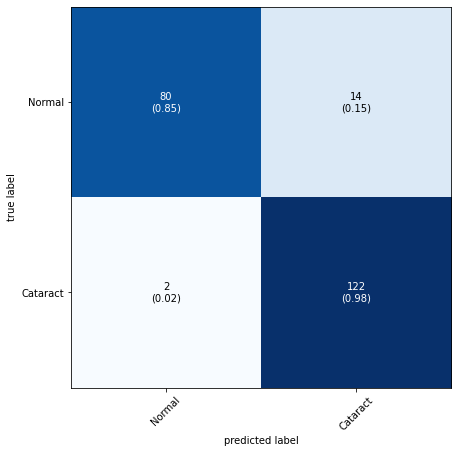

In [26]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

# Model prediction

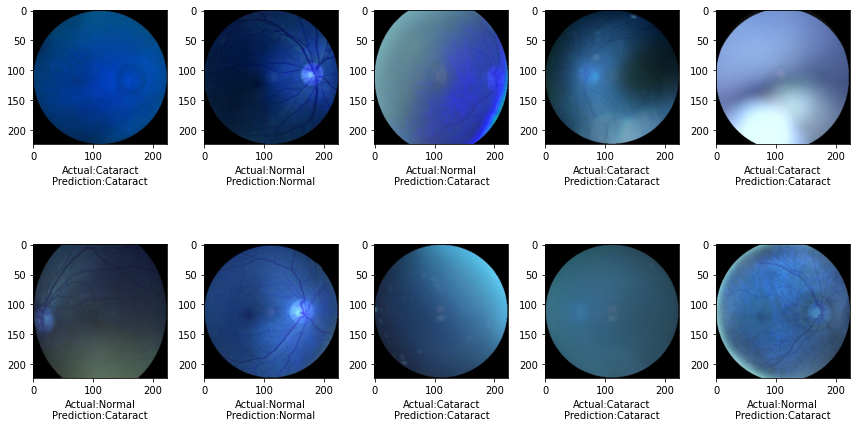

In [27]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 